# HPC Assignment 1
##### S/N: 16014073
##### Name: Gergely Eory

# Question 1

The aim is to calculate matrix-vector product of a (N,N) sized square (sparse) Matrix $A$ and a vector $\vec{v}$ of length N, $ \vec{y} = A \vec{v}$. The elements of the result vector are given by 

$$y_i = \sum_{i=0}^{N-1} {M}_{i,j}  \times v_{j}$$

Since $A$ is a sparse matrix, the a majority of the data entries are zero. In the Compressed Sparse Row (CSR) format, only the nonzero entries $A_{i,j}$ are stored. The value is stored in the data vector $D$, the corresponding column index is stored in the index vector. I.e. the index corresponding to $D_k = D(k)$ is $j_k = I(k)$. Finally the vector indptr $P$ specifies at which k indices the next row of the matrix begins. This way, the data points $D(k) : P(i) \leq k < P(i+1) $ belong to the same row. The elements of the result vector using the CSR format can be obtained using the following summation

$${y}_i = \sum_{k=P(i)}^{P(i+1)} D(k) \times v(I(k))$$

In [1]:
from __future__ import absolute_import, print_function
import numpy as np
import pyopencl as cl
from scipy import sparse
from scipy.sparse.linalg import LinearOperator
from scipy.sparse import csr_matrix
import time


class Timer:
    '''
    Class for measuring time, returns time interval
    taken by the code execution.
    '''
    def __enter__(self):
        self.start = time.time()
        return self
    
    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start


In [2]:
def rand_csr(N,density=0.4):
    '''
    Generate a random sparce matrix in CSR format of the specified density.
    '''
    
    # Create random square sparse matrix in COO format
    coo_sparse = sparse.random(N,N,density,dtype='float32')
    # Convert to CSR format and return
    return sparse.csr_matrix(coo_sparse)

In [6]:
class Sparce(LinearOperator):
    '''
    Class derived from LinearOperator, initialised with a sparce matrix in
    the CSR format. It overrides the _matvec function to implement 
    algorithm for CSR multiplication, accelerated by OpenCL.
    '''
    def __init__(self, inMat):
        '''
        Initiaises Sparce matrix with input type scipy.sparse.csr_matrix.
        shape and dtype fields are required by LinearOperator. 
        '''
        self.shape = inMat.get_shape()
        self.dtype = 'float32'
        self.data = inMat.data
        self.indices = inMat.indices
        self.indptr = inMat.indptr
        
    def _matvec(self, v):
        '''
        OpenCL implementation of product of sparce matrix object with vector v.
        Returns A*v. Dimensions of v should match first dimension of the sparce matrix
        '''
        platform = cl.get_platforms()[0]    # Select the first platform [0]
        device = platform.get_devices()[0]  # Select the first device on this platform [0]
        ctx = cl.Context([device])
        queue = cl.CommandQueue(ctx)  # Create (non-custom) command queue
        mf = cl.mem_flags             # Memory flags
        
        # 4 compute units available on my CPU (2 cores + HT)
        # AVX2 -> 256 bit AVX --> double4
  
        vec =  v.astype(np.float32)
        data = self.data.astype(np.float32)    # Data vector
        ind = self.indices.astype(np.int32)   # Vector of column indices
        indptr  = self.indptr.astype(np.int32)    # Index pointer of column

        #Create buffers
        data_buff = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=data)
        ind_buff = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=ind)
        indptr_buff  = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=indptr)
        vec_buff  = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=vec)
        res_buff = cl.Buffer(ctx,mf.WRITE_ONLY,vec.nbytes)

        N = np.float32(len(indptr) - 1)    # Length of the output vector

        ### Create a kernel which carries out the CSR multiplication
        matvec_kernel ="""
        __kernel void matvec( const int N,
                          __global const float * data,
                          __global const int * index,
                          __global const int * indptr,
                          __global const float * vec,
                          __global float * res )
        {
        
        int gid = get_global_id(0);
        
        float acc = 0.0f;
        
        for (int k = indptr[gid]; k < indptr[gid + 1]; k++)
            {
            acc += data[k] * vec[index[k]];
            }
        
        res[gid] = acc;
        } """

        
        # Build kernel
        prg = cl.Program(ctx,matvec_kernel).build()
        
        # Create result buffer in python and execute kernel
        res_np = np.empty_like(vec).astype(np.float32)
        prg.matvec(queue,vec.shape,None,np.int32(N),
            data_buff,ind_buff,indptr_buff,vec_buff,res_buff)
        cl.enqueue_copy(queue, res_np, res_buff).wait()

        return res_np


    
    def _matvecsimd(self, v):
        '''
        Vectorised sparse matrix product.
        Breaks problem down into double4 vector types, carries out multiplications
        in vector form, then accumulates the values corresponding to each matrix
        row, therefore to each result element.
        '''
        platform = cl.get_platforms()[0]    # Select the first platform [0]
        device = platform.get_devices()[0]  # Select the first device on this platform [0]
        ctx = cl.Context([device])
        queue = cl.CommandQueue(ctx)  # Create (non-custom) command queue
        mf = cl.mem_flags             # Memory flags
        
        # 4 compute units available on my CPU (2 cores + HT)
        # AVX2 -> 256 bit AVX --> double4

        vec =  v.astype(np.float32)
        data = self.data.astype(np.float32)    # Data vector
        ind = self.indices.astype(np.int32)   # Vector of column indices
        indptr  = self.indptr.astype(np.int32)    # Index pointer of column
        
        ### Pad data and indices to be divisible by 4
        remainder = np.uint32(np.size(data)%4)
        if remainder != 0:
            data = np.concatenate([data, np.zeros(4 - remainder)]).astype(np.float32)
            ind = np.concatenate([ind, np.zeros(4 - remainder)]).astype(np.uint32)

        iteration_len = np.size(data)

        #Create buffers
        data_buff = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=data)
        ind_buff = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=ind)
        indptr_buff  = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=indptr)
        vec_buff  = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=vec)
        res_buff = cl.Buffer(ctx,mf.WRITE_ONLY,vec.nbytes)
        res_tmp_buff = cl.Buffer(ctx, mf.READ_WRITE, data.nbytes)


        matvec_simd_kernel ="""
        __kernel void mult(__global const float * data,
                            __global const int * index,
                            __global const float * vec,
                            __global float * resTmp )
        {
        
            int gid = get_global_id(0);
            
            double4 dataSlice;
            double4 vecSlice;
            double4 resSlice;

            dataSlice = (double4)(data[gid*4+0],
                                data[gid*4+1],
                                data[gid*4+2],
                                data[gid*4+3]);

            vecSlice = (double4)(vec[index[gid*4+0]],
                                vec[index[gid*4+1]],
                                vec[index[gid*4+2]],
                                vec[index[gid*4+3]]);

            resSlice = dataSlice * vecSlice;

            resTmp[gid*4+0] = resSlice.s0;
            resTmp[gid*4+1] = resSlice.s1;
            resTmp[gid*4+2] = resSlice.s2;
            resTmp[gid*4+3] = resSlice.s3;
        
        }

        __kernel void add(__global const int* indptr,
                                __global const float* resTmp,
                                __global float* res) {

            int gid = get_global_id(0);
            float acc = 0.0f;

            for(uint j = indptr[gid]; j < indptr[gid+1]; j++){
                acc += resTmp[j];
            }

            res[gid] = acc;
        }
        """

        # Build kernel
        prg = cl.Program(ctx,matvec_simd_kernel).build()
        
        # Execute matrix vector multiplication using OpenCL kernel
        prg.mult(queue, (int(iteration_len/4), ), None,
                    data_buff, ind_buff, vec_buff, res_tmp_buff)
        prg.add(queue, (np.size(indptr) - 1,), None, 
                    indptr_buff, res_tmp_buff, res_buff)

        res = np.empty_like(v)
        cl.enqueue_copy(queue, res, res_buff).wait()
        
        # Trim result so only the original size vector is returned without padding.
        return res[0:np.size(v)]

In the function _matvecSIMD(), the problem needed to be broken down into two functions. Due to the nature of the CSR format, it is not guaranteed that 4 consecutive data points are in the same row of the matrix. Hence the multiplication is first carried out ofer all the non-zero data points. This is possible because matrix multiplication works on a row-by-column basis. For each data point we know its column index, so we know which vector value to multiply it with. We store all the products in a temporary buffer, then a second function accumulates all the products that belong in the same row of the matrix described by indptr, and returns the result vector.

In [8]:
def runCode(N):
    '''
    Generates a random Sparce matrix of dimensions N*N in CSR format.
    Also generates a random vector of length N, and carries out the 
    multiplication using both OpenCL functions, with and without SIMD optimisation.
    '''
    vec = np.random.rand(N).astype(np.float32)
    foo = rand_csr(N, 0.10)
    bar = Sparce(foo)

    with Timer() as t1:
        a = bar._matvec(vec)

    with Timer() as t2:
        b = bar._matvecsimd(vec)

    print("time to run without SIMD: {0}".format(t1.interval))
    print("time to run with SIMD: {0}".format(t2.interval))

runCode(10000)

time to run without SIMD: 0.04638409614562988
time to run with SIMD: 0.05095791816711426


In the Jupyter notebook, there seems to be no difference between the two functions in runtime. Both run extremely fast considering the size of the data. Most time is taken by generating the large sparse matrix.
On the other hand, when I ran the code as a *.py file from te terminal, the SIMD implementation was consistently around 20% quicker(which might be explained by the CPU clock speed turboing up, but thought it was worth mentioning).

# Question 2

The aim of this question is to solve the following Poisson equation:
$$-\nabla^2 u(x,y) = 1$$ for $0<x,y<M$ However to solve this equation boundary conditions are required. We use Dirilecht boundary conditions, as we require that $$-\nabla^2 u(x,y)=0$$ for the 'edge' of the field, ie for $(x=0,0 \leq y \leq M)$, $(x=M,0 \leq y \leq M)$, $(0 \leq x\leq M,y=0)$ and $(0\leq x\leq M,y=M)$.

This system can be descritized into a grid of  $n \times n$ values points where each point is given by $x_i = i/(n-1)$ and $y_i = j/(n-1)$ for $i, j = 0,...,n-1$, According to the Dirilecht boundary conditions for $u_{i,j}$ on the boundary have to be 0 for [i,j] = [0,y], [n-1,y], [x,0] and [x,n-1]. Howevever this leaves $M^2 = (n-2)^2$ inner values for $u_{i,j}$ for $i,j = 1,...,M$ values still unknown, which need to be solved. For this we also need to discretize the RHS of our poisson equation, which can be done through the "boundary grid" $b_{i,j}$, which likewise is equal to zero on the boundary points like $u_{i,h}$ however the the $M^2$ inner points will be all equal to $1$. Note that distance between each point is given by $h=\frac{1}{n-1} = \frac{1}{M+1}$.

The discretizated version of del ($-\nabla^2$) according to the 5 point Stencyl Algorythm is given by 

$$ del(i,j) =  (-\nabla^2 u)_{i,j} = \frac{4u(i,j)-u(i-1,j)-u(i+1,j)-u(i,j-1)-u(i,j+1)}{h^2} $$.

Note that I temporarily switched notation from $u_(i,j)$ to $u(i,j)$ for visual convenience. The factor of  $1/{h^2}$ just becomes $(M+1)$^2. This however must only be applied to the inner $M^2$ number of points (not the boundary zero points), as applying it a boundary zero points, would require the value of $u(i,j)$ outside our system. However in order to match conditions of the of the boundary grid $b$, it is therefore required that $(-\nabla^2 u)_{i,j}=0$ for [i,j] corresponding to before listed set of boundary zeros.


To solve this system using the Conjugate Gradient (cg) iterative solver of Scipy's linear algebra module, we need to represent the discretized system as 1D vector rather than a 2D grid. This can by simply flattening the grid into a $n^2$ long 'vector' (technically an array of dimension (n^2,) within the code), where each point [i,j] point in the grid corresponds to entry
$$ L = i\cdot n + j $$ in the vector.

In [6]:
from __future__ import absolute_import, print_function
import numpy as np
import pyopencl as cl
from scipy import sparse
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import aslinearoperator
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import cg
from scipy.linalg import norm
import matplotlib.pyplot as plt
from pylab import imshow, jet



Datatypes had to be specified throughout in order for OpenCL to be able to run the calculations. Integer values are specified as int32, while data values are stored as double precision floating point numbers. Using float instead of double could improve performance, but due to precision errors, the CG solution using float does not converge for N > 28. In this case the CG solver runs N^2 iterations, which takes a long time. Furhtermore, the residual gets close to the tolerance value (default = 1e-5), and then starts to increase as the solution slowly diverges. (The actual behaviour might be bounded instead of diverging, cannot tell without knowing the CG algorythm in detail. Bt the point is the same, it does not converge in less than N^2 iterations.)

In [7]:
#function implementing OpenCL five point stencil
def mv(u):
    '''
    Takes a matrix U in a flattened vector form u, and applies the
    five point stencil of the Laplace operator in 2D to the interior points.
    Returns the result in a matrix format also flattened to a vector.
    LinearOperator with this funcion for _matvec() can be used to solve the 
    Laplace/Poisson equation with Dirichlet boundary conditions using the 
    Scipy CG iterative solver.
    '''
    M = np.int32(np.sqrt(len(u)))

    platform = cl.get_platforms()[0]    # Select the first platform [0]
    device = platform.get_devices()[0]  # Select the first device on this platform [0]
    ctx = cl.Context([device])
    # Create (non-custom) command queue
    queue = cl.CommandQueue(ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)
    mf = cl.mem_flags             # Memory flags
        
    #Create a buffer on the device containing the vector u
    uDevice = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=u)

    resDevice = cl.Buffer(ctx, mf.WRITE_ONLY, u.nbytes)

    stencil_kernel = """
    __kernel void fpStencil(const __global double* u,
                            const int uSize,
                            const int M,
                            __global double* resU) 
    {

        int gid = get_global_id(0);

        resU[gid] = (4 * u[gid] - u[gid - M] - u[gid + M] - u[gid - 1] - u[gid + 1]) * M * M;

        if (gid < M) {
            resU[gid] = 0;
        }

        if  (gid > uSize - M) {
            resU[gid] = 0;
        }

        if (gid%M == 0) {
            resU[gid] = 0;
        }

        if (gid%M == M - 1) {
            resU[gid] = 0;
        }
    }
    """

    resU = np.empty_like(u)
    prg = cl.Program(ctx, stencil_kernel).build()
    prg.fpStencil(queue, u.shape, None, uDevice, np.int32(u.size), M, resDevice).wait()
    cl.enqueue_copy(queue, resU, resDevice).wait()

    return np.float64(resU)

In [8]:
def runCG(N):
    '''
    creates a LinearOperator corresponding to the problem on an N*N grid,
    and the appropriate RHS vectr and uses the linalg.cg function to solve
    the system iteratively. It also uses the callback function to store 
    the residual at each step, and the total number of iterations.
    '''

    #RHS matrix including zero boundary conditions, then flattened to vector
    fMat = np.ones((N,N))
    for i in range(N):
        for j in range(N):
            if(i == 0 or j == 0 or i == N-1 or j == N-1):
                fMat[i][j] = 0
    fVec = fMat.flatten().astype('float64')

    #Random starting matrix U, flattened to vector
    uMat = np.random.rand(N,N)
    for i in range(N):
        for j in range(N):
            if (i == 0 or j == 0 or i == N-1 or j == N-1):
                uMat[i][j] = 0

    uVec = uMat.flatten()


    def cgCallback(xk):
        '''
        Function to extract the residual at each iteration, which allows us to
        study the convergence of the solution.
        '''
        r = norm(fVec - mv(xk)) / norm(fVec)
        errors.append(r)

    errors = []  #Array of residuals at each iteration
    boo = LinearOperator(shape = (N*N,N*N), matvec = mv, dtype = np.float64)
    resVec = cg(boo, np.float64(fVec), callback = cgCallback)
    resMat = np.asarray(np.reshape(resVec[0], (N,N)))
    iterations = len(errors)
    
    # Return convergent solution, residual at each iteration and total number of iterations
    output = [resMat, errors, iterations]
    
    return output

In [9]:
iter = []
err = []
results = []

### Takes some time to run
for n in np.arange(5,256,10):
    run = runCG(n)
    iter.append(run[2])
    err.append(run[1])
    results.append(run[0])

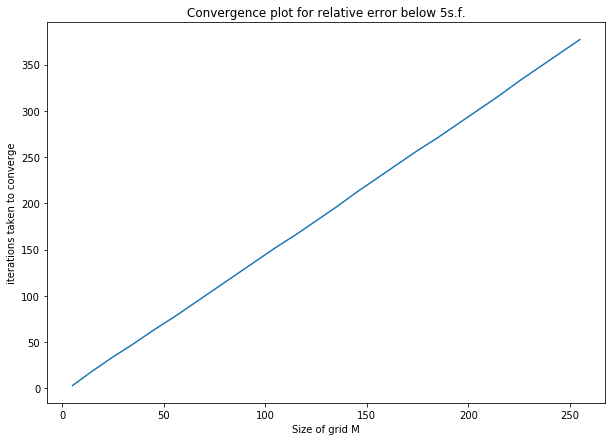

In [10]:
plt.figure(figsize = (10,7))
plt.plot(np.arange(5, 256, 10),iter)
plt.title('Convergence plot for relative error below 5s.f.')
plt.xlabel('Size of grid M')
plt.ylabel('iterations taken to converge');

We can see that the number of iterations taken to converge to a desired precision increases linearly with the size of the problem. The default precision of the CG solver requires the residual to be lower than 10^-5. By setting a different precision limit, the slope of the graph could be changed.

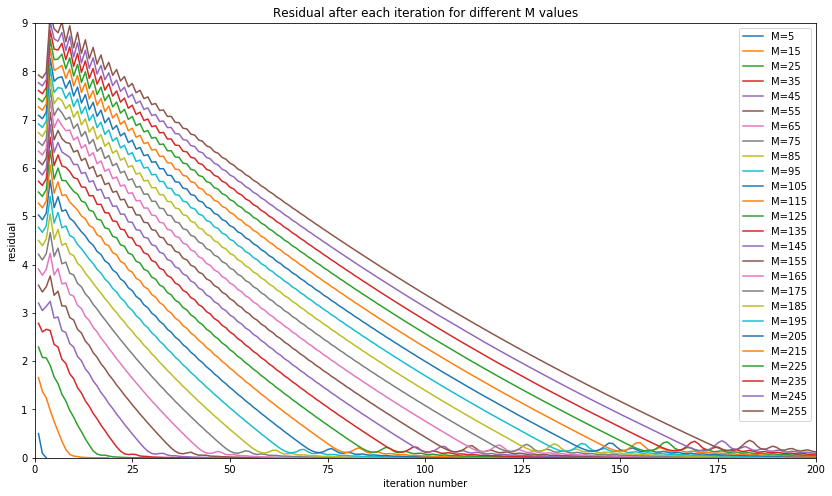

In [11]:
%matplotlib inline

plt.figure(figsize = (14,8))
for i in range(len(err)):
    plt.plot(np.arange(1,len(err[i])+1), err[i], label = "M="+str(i*10+5))
    
plt.legend(loc='upper right');
plt.title('Residual after each iteration for different M values')
plt.xlabel('iteration number')
plt.ylabel('residual');
plt.axis([0,200,0,9]);

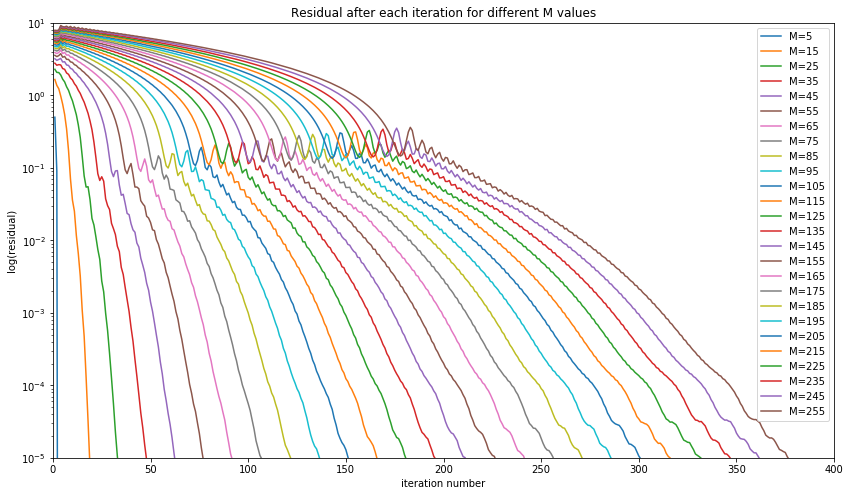

In [12]:
%matplotlib inline

plt.figure(figsize = (14,8))
for i in range(len(err)):
    plt.semilogy(np.arange(1,len(err[i])+1), err[i], label = "M="+str(i*10+5))
    
plt.legend(loc='upper right');
plt.title('Residual after each iteration for different M values')
plt.xlabel('iteration number')
plt.ylabel('log(residual)');
plt.axis([0,400,0.00001,10]);

Finally, some pretty plots for different grid size solutions, finishing with a 500*500 grid

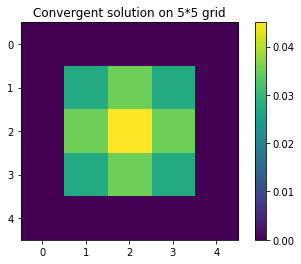

In [13]:
imshow(results[0]);
plt.colorbar(orientation='vertical');
plt.title('Convergent solution on 5*5 grid');

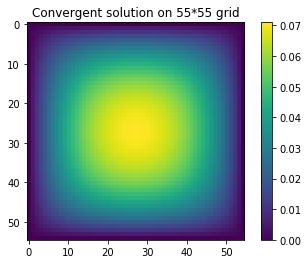

In [14]:
imshow(results[5]);
plt.colorbar(orientation='vertical');
plt.title('Convergent solution on 55*55 grid');

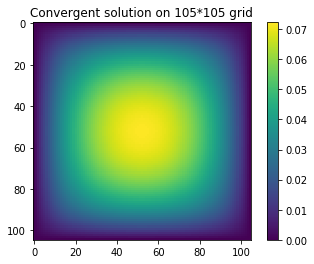

In [15]:
imshow(results[10]);
plt.colorbar(orientation='vertical');
plt.title('Convergent solution on 105*105 grid');

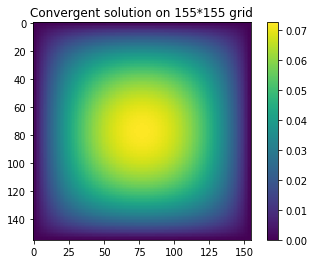

In [16]:
imshow(results[15]);
plt.colorbar(orientation='vertical');
plt.title('Convergent solution on 155*155 grid');

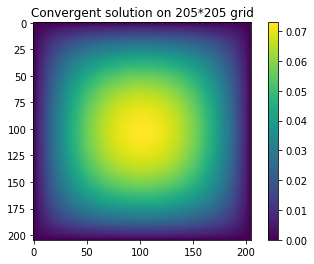

In [17]:
imshow(results[20]);
plt.colorbar(orientation='vertical');
plt.title('Convergent solution on 205*205 grid');

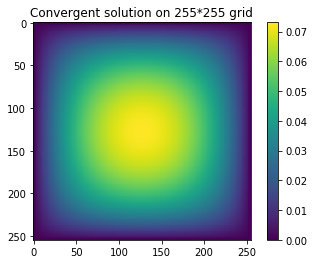

In [18]:
imshow(results[25]);
plt.colorbar(orientation='vertical');
plt.title('Convergent solution on 255*255 grid');

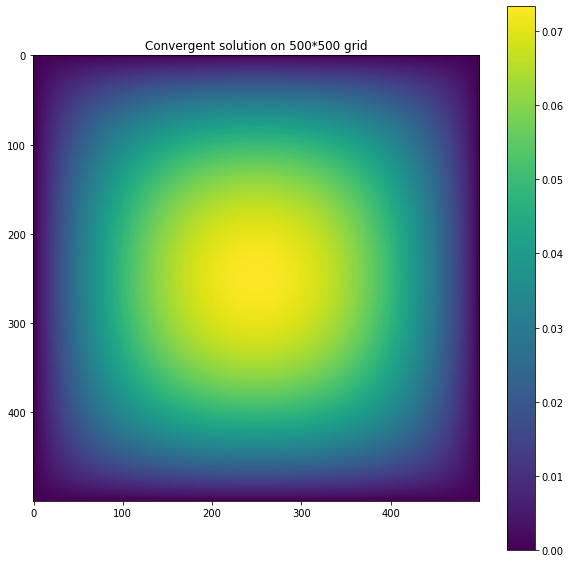

In [19]:
plt.figure(figsize = (10,10))
foobar = runCG(500)
imshow(foobar[0])
plt.colorbar(orientation='vertical');
plt.title('Convergent solution on 500*500 grid');